In [ ]:
!pip install -q kaggle

from google.colab import files
files.upload()  # Upload the kaggle.json file

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sowaadrahman","key":"ce2fab7c1ebaf7fc9160542dc7722a29"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d markdaniellampa/fish-dataset


Dataset URL: https://www.kaggle.com/datasets/markdaniellampa/fish-dataset
License(s): Community Data License Agreement - Sharing - Version 1.0
100% 1.58G/1.58G [00:20<00:00, 35.8MB/s]
100% 1.58G/1.58G [00:20<00:00, 82.3MB/s]


**UNZIP AND DELETE ZIP FILE**

In [ ]:
import os
import zipfile


zip_file_path = "fish-dataset.zip"
# Extract the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('dataset')

print("Extraction complete.")


if os.path.exists(zip_file_path):
    os.remove(zip_file_path)
    print(f"{zip_file_path} deleted.")
else:
    print(f"{zip_file_path} not found.")


Extraction complete.
fish-dataset.zip deleted.


**DATA PREPROCESSING**

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define paths for the train, validation, and test datasets
train_dir = '/content/dataset/FishImgDataset/train'
val_dir = '/content/dataset/FishImgDataset/val'
test_dir = '/content/dataset/FishImgDataset/test'


train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# Training data generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical')

# Validation data generator
val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical')

# Test data generator
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical')


Found 8791 images belonging to 31 classes.
Found 2751 images belonging to 31 classes.
Found 1760 images belonging to 31 classes.


**CNN MODEL**

In [ ]:
from tensorflow.keras import layers, models

# Define CNN Model
model = models.Sequential()

# First Convolutional Layer
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))

# Second Convolutional Layer
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Third Convolutional Layer
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Fully connected layer
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(train_generator.num_classes, activation='softmax'))

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Model summary
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      18,940,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 31)                  │          15,903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,049,567 (72.67 MB)

 Trainable params: 19,049,567 (72.67 MB)

 Non-trainable params: 0 (0.00 B)

**EPOCHS**

In [ ]:
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=val_generator)


Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


275/275 ━━━━━━━━━━━━━━━━━━━━ 118s 400ms/step - accuracy: 0.1851 - loss: 3.1035 - val_accuracy: 0.3566 - val_loss: 2.2799
Epoch 2/15
275/275 ━━━━━━━━━━━━━━━━━━━━ 123s 350ms/step - accuracy: 0.3840 - loss: 2.1780 - val_accuracy: 0.4853 - val_loss: 1.8143
Epoch 3/15
275/275 ━━━━━━━━━━━━━━━━━━━━ 100s 355ms/step - accuracy: 0.5144 - loss: 1.6804 - val_accuracy: 0.5918 - val_loss: 1.4719
Epoch 4/15
275/275 ━━━━━━━━━━━━━━━━━━━━ 99s 354ms/step - accuracy: 0.6150 - loss: 1.3411 - val_accuracy: 0.7085 - val_loss: 1.0254
Epoch 5/15
275/275 ━━━━━━━━━━━━━━━━━━━━ 97s 347ms/step - accuracy: 0.6708 - loss: 1.1058 - val_accuracy: 0.7368 - val_loss: 0.9241
Epoch 6/15
275/275 ━━━━━━━━━━━━━━━━━━━━ 96s 341ms/step - accuracy: 0.7330 - loss: 0.9159 - val_accuracy: 0.7892 - val_loss: 0.7045
Epoch 7/15
275/275 ━━━━━━━━━━━━━━━━━━━━ 143s 342ms/step - accuracy: 0.7789 - loss: 0.7542 - val_accuracy: 0.8182 - val_loss: 0.6567
Epoch 8/15
275/275 ━━━━━━━━━━━━━━━━━━━━ 103s 367ms/step - accuracy: 0.8158 - loss: 0.6323 

**TEST ACCURACY**

In [ ]:
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc:.4f}')


55/55 ━━━━━━━━━━━━━━━━━━━━ 11s 194ms/step - accuracy: 0.8401 - loss: 0.7294
Test accuracy: 0.8239


**RESULTS VIZUALIZATION**

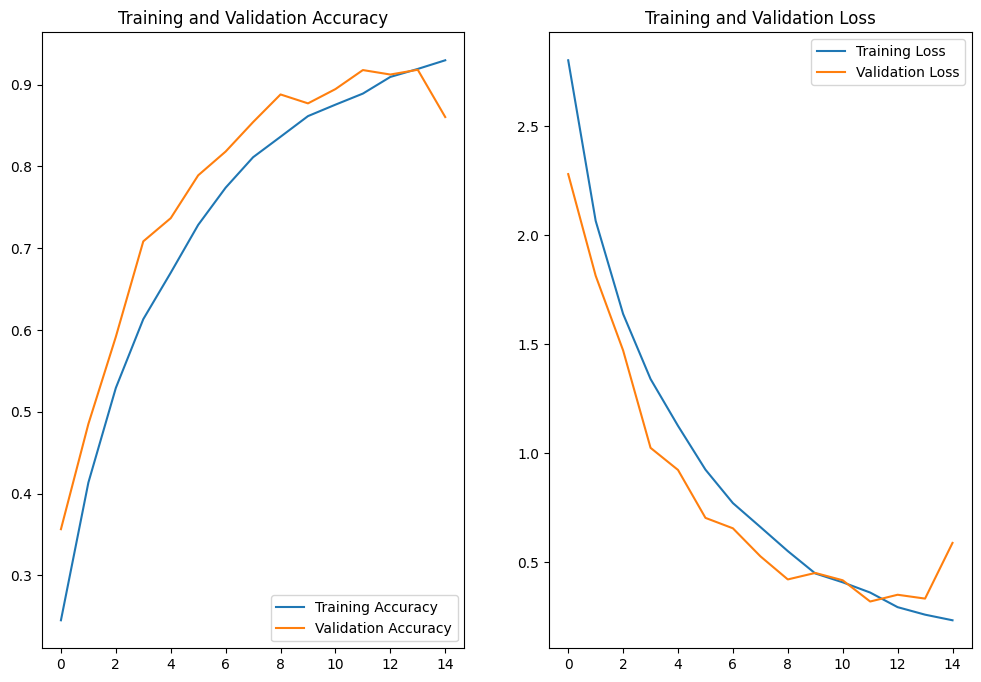

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(15)

plt.figure(figsize=(12, 8))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


**SAVING MODEL**

In [ ]:
model.save('fish_classification_model.h5')


**TEST RESULT**

In [ ]:
from tensorflow.keras.models import load_model
import numpy as np
from tensorflow.keras.preprocessing import image


model = load_model('fish_classification_model.h5')


img_path = '/content/dataset/FishImgDataset/test/Bangus/Bangus 103.jpg'
img = image.load_img(img_path, target_size=(150, 150))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0


prediction = model.predict(img_array)
predicted_class = np.argmax(prediction, axis=1)


class_labels = {v: k for k, v in train_generator.class_indices.items()}
print(f"Predicted fish category: {class_labels[predicted_class[0]]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 862ms/step
Predicted fish category: Bangus
